In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
from replay_trajectory_classification.simulate import simulate_neuron_with_place_field
from track_linearization import get_linearized_position
from replay_trajectory_classification import make_track_graph
import numpy as np


def generate_position(traversal_path, track_graph, step_size=0.020, n_traversals=5):
    points = []
    for _ in range(n_traversals):
        for node1, node2 in traversal_path:
            x1, y1 = track_graph.nodes[node1]['pos']
            x2, y2 = track_graph.nodes[node2]['pos']
            dx, dy = x2 - x1, y2 - y1
            dist = np.sqrt(dx**2 + dy**2)
            n_points = int(dist // step_size)
            w = np.linspace(0, 1, n_points)
            points.append((x1 + dx * w, y1 + dy * w))

    return np.concatenate(points, axis=1).T

def get_unique_place_field_centers(place_field_centers):
    return np.unique((place_field_centers * 10_000).astype(int), axis=0) / 10_000

def make_two_environment_data():
    node_positions1 = [(40, 80), # 0
                       (40, 0),  # 1
                       (0, 0),   # 2
                       (0, 80),  # 3
                       (80, 0),  # 4
                       (80, 80), # 5
                       ]
    edges1 = [(0, 1),
             (1, 2),
             (2, 3),
             (1, 4),
             (4, 5)
            ]
    track_graph1 = make_track_graph(node_positions1, edges1)
    
    traversal_path1 = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0),
                       (0, 1), (1, 4), (4, 5), (5, 4), (4, 1), (1, 0)]
    position1 = generate_position(traversal_path1, track_graph1)

    
    edge_order1 = ((0, 1),
                  (1, 2),
                  (2, 3),
                  (1, 4),
                  (4, 5)
                 )
    edge_spacing1 = (30, 0, 30, 0)
    position_df1 = get_linearized_position(position1,
                                           track_graph1,
                                           edge_order=edge_order1,
                                           edge_spacing=edge_spacing1,
                                           use_HMM=False)
    sampling_frequency = 1000

    place_field_centers1 = generate_position(traversal_path1, track_graph1, step_size=10, n_traversals=1)
    place_field_centers1 = get_unique_place_field_centers(place_field_centers1)
    
    spikes1 = np.stack([simulate_neuron_with_place_field(center, position1,
                                                        sampling_frequency=sampling_frequency,
                                                        variance=6.0**2)
                       for center in place_field_centers1], axis=1)
    
    edges2 = [(0, 1), (1, 2), (2, 3)]
    node_positions2 = [
                   (0, 40),
                   (0, 80),
                   (0, 120),
                   (0, 160),
                   ]
    
    edge_order2 = ((0, 1), (1, 2), (2, 3))
    edge_spacing2 = 0
    track_graph2 = make_track_graph(node_positions2, edges2)
    
    traversal_path2 = [(0, 1), (1, 2), (2, 3),
                       (3, 2), (2, 1), (1, 0)]
    position2 = generate_position(traversal_path2, track_graph2)
    position_df2 = get_linearized_position(position2,
                                          track_graph2,
                                          edge_order=edge_order2,
                                          edge_spacing=edge_spacing2,
                                          use_HMM=False)
    
    place_field_centers2 = generate_position(traversal_path2, track_graph2, step_size=10, n_traversals=1)
    place_field_centers2 = get_unique_place_field_centers(place_field_centers2)
    
    spikes2_temp = np.stack([simulate_neuron_with_place_field(center, position2,
                                                    sampling_frequency=sampling_frequency,
                                                    variance=6.0**2)
                   for center in place_field_centers2], axis=1)
    spikes2 = np.zeros((spikes2_temp.shape[0], spikes1.shape[1]))
    spikes2[:, [7, 17, 27, 4, 14, 24, 10, 1, 12, 23]] = spikes2_temp
    
    return (spikes1, spikes2,
            position_df1, position_df2,
            track_graph1, track_graph2, 
            place_field_centers1, place_field_centers2,
            position1, position2,
            edge_order1, edge_spacing1,
            edge_order2, edge_spacing2
           )

In [3]:
(spikes1, spikes2,
 position_df1, position_df2,
 track_graph1, track_graph2, 
 place_field_centers1, place_field_centers2,
 position1, position2,
 edge_order1, edge_spacing1,
 edge_order2, edge_spacing2,
) = make_two_environment_data()

Text(0.5, 0, 'X-Position')

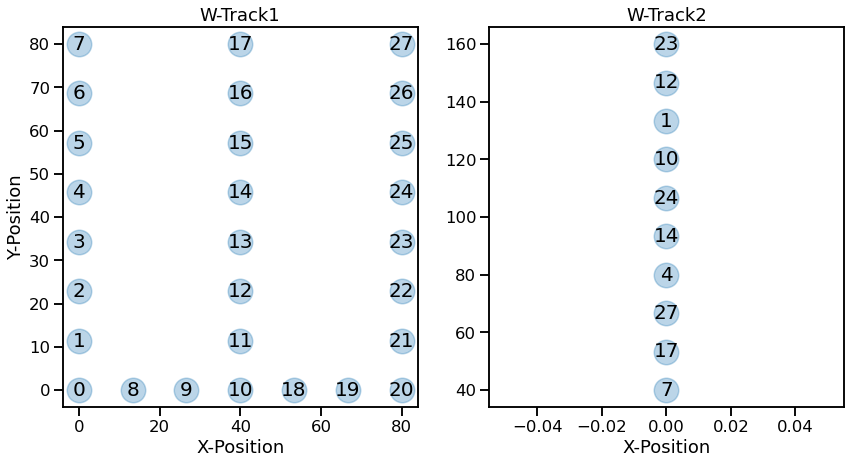

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].scatter(place_field_centers1[:, 0], place_field_centers1[:, 1], alpha=0.3, s=600, zorder=0)
for ind, center in enumerate(place_field_centers1):
    axes[0].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[0].set_title('W-Track1')
axes[0].set_ylabel('Y-Position')
axes[0].set_xlabel('X-Position')
    
axes[1].scatter(place_field_centers2[:, 0], place_field_centers2[:, 1], alpha=0.3, s=600, zorder=0)
for ind, center in zip([7, 17, 27, 4, 14, 24, 10, 1, 12, 23], place_field_centers2):
    axes[1].text(center[0], center[1], ind, ha='center', va='center', fontsize=20, zorder=1)
axes[1].set_title('W-Track2')
axes[1].set_xlabel('X-Position')

In [5]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45643/status,
Dashboard: http://127.0.0.1:45643/status,Workers: 8
Total threads: 56,Total memory: 376.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35869,Workers: 8
Dashboard: http://127.0.0.1:45643/status,Total threads: 56
Started: Just now,Total memory: 376.59 GiB
Comm: tcp://127.0.0.1:36759,Total threads: 7
Dashboard: http://127.0.0.1:41103/status,Memory: 47.07 GiB
Nanny: tcp://127.0.0.1:43745,


In [6]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform

environments = (
    Environment('wtrack', track_graph=track_graph1, edge_order=edge_order1, edge_spacing=edge_spacing1),
    Environment('linear_track', track_graph=track_graph2, edge_order=edge_order2, edge_spacing=edge_spacing2))

continuous_transition_types = [[RandomWalk('wtrack'),         Uniform('wtrack', 'linear_track')],
                               [Uniform('linear_track', 'wtrack'), RandomWalk('linear_track')]]

classifier = SortedSpikesClassifier(
    environments=environments,
    continuous_transition_types=continuous_transition_types,
)
classifier

SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack', environment2_name='linear_track')],
                                                    [Uniform(environment_name='linear_track', environment2_name='wtrack'),
                                                     RandomWalk(environment_name='linear_track', movement_var=6.0, movement_mean=0.0)]],
                       discr...
                                     Environment(environment_name='linear_track', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7f5a86d297c0>, edge_order=((0, 1), (1, 2), (2, 3)), edge_spacing=0, is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       knot_spac

In [7]:
position = np.concatenate((position_df1.linear_position.values,
                           position_df2.linear_position.values))
spikes = np.concatenate((spikes1, spikes2))
environment_labels = np.concatenate((['wtrack'] * spikes1.shape[0],
                                     ['linear_track'] * spikes2.shape[0],
                                    ))
environment_names_to_state = ['wtrack', 'linear_track']
classifier.fit(
    position=position,
    spikes=spikes,
    environment_labels=environment_labels,
    environment_names_to_state=environment_names_to_state,
)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorr

/home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/regularized_glm/core.py:83: RuntimeWarning: divide by zero encountered in true_divide
  weights = prior_weights / (family.variance(predicted_response)
Weighted least squares failed. Returning NaN coefficiients.
/home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/regularized_glm/core.py:83: RuntimeWarning: divide by zero encountered in true_divide
  weights = prior_weights / (family.variance(predicted_response)
Weighted least squares failed. Returning NaN coefficiients.
/home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/regularized_glm/core.py:83: RuntimeWarning: divide by zero encountered in true_divide
  weights = prior_weights / (family.variance(predicted_response)
Weighted least squares failed. Returning NaN coefficiients.
/home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/regularized


Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
/home/edeno/miniconda3/envs/replay_trajectory_classification/lib/python3.8/site-packages/regularized_glm/core.py:83: RuntimeWarning: divide by zero encountered in true_divide
  weights = prior_weights / (family.variance(predicted_response)
Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.
Weighted least squares failed. Returning NaN coefficiients.



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


SortedSpikesClassifier(continuous_transition_types=[[RandomWalk(environment_name='wtrack', movement_var=6.0, movement_mean=0.0),
                                                     Uniform(environment_name='wtrack', environment2_name='linear_track')],
                                                    [Uniform(environment_name='linear_track', environment2_name='wtrack'),
                                                     RandomWalk(environment_name='linear_track', movement_var=6.0, movement_mean=0.0)]],
                       discr...
                                     Environment(environment_name='linear_track', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7f5a86d297c0>, edge_order=((0, 1), (1, 2), (2, 3)), edge_spacing=0, is_track_interior=None, position_range=None, infer_track_interior=True)),
                       infer_track_interior=True,
                       initial_conditions_type=UniformInitialConditions(),
                       knot_spac

In [8]:
def make_sequence(neuron_sequence, n_neurons=28, step=1):
    neuron_sequence = np.asarray(neuron_sequence)
    n_time = step * len(neuron_sequence)
    spike_time_ind = np.arange(0, n_time, step)
    spikes = np.zeros((n_time, n_neurons))
    
    spikes[(spike_time_ind, neuron_sequence)] = 1
    
    return spikes

In [9]:
import copy
from cycler import cycler

def plot_replay_results(test_spikes, classifier, results):
    time = np.arange(test_spikes.shape[0]) / 1000
    fig, axes = plt.subplots(4, 1, constrained_layout=True, figsize=(7, 8), sharex=True)
    time_ind, spike_ind = np.nonzero(test_spikes)
    mask1 = ~classifier.environments[0].is_track_interior_
    mask1 = mask1.astype(float)
    mask1[mask1 == 1] = np.nan
    mask1[mask1 == 0] = 1
    mask1 = mask1[:, np.newaxis]

    mask2 = ~classifier.environments[1].is_track_interior_
    mask2 = mask2.astype(float)
    mask2[mask2 == 1] = np.nan
    mask2[mask2 == 0] = 1
    mask2 = mask2[:, np.newaxis]

    cmap = copy.copy(plt.cm.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=0.8)
    
    axes[0].scatter(time[time_ind], spike_ind, clip_on=False, color='black', s=50)
    axes[0].set_ylim((0, 28))
    axes[0].set_ylabel('Cells')
    
    t, x = np.meshgrid(time, classifier.environments[0].edges_[0])
    axes[1].pcolormesh(t, x, results['acausal_posterior'][:, 0].T * mask1,
                       cmap=cmap, vmin=0.0, vmax=0.1)
    axes[1].set_title('W-Track')
    axes[1].set_ylabel('Position')    
    
    t, x = np.meshgrid(time, classifier.environments[1].edges_[0])
    n_position_bins = classifier.environments[1].is_track_interior_.shape[0]
    axes[2].pcolormesh(t, x, results['acausal_posterior'][:, 1, :n_position_bins].T * mask2,
                       cmap=cmap, vmin=0.0, vmax=0.1)
    axes[2].set_title('Linear Track')
    axes[2].set_ylabel('Position') 
    
    
    axes[3].set_prop_cycle(cycler(color=['r', 'g', 'b', 'y']))
    axes[3].plot(time, results['acausal_posterior'].sum(axis=2),
                 label=['W-Track', 'Linear Track'], clip_on=False)
    axes[3].set_ylim((0, 1))
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel('Time')
    axes[3].legend()
    sns.despine()

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


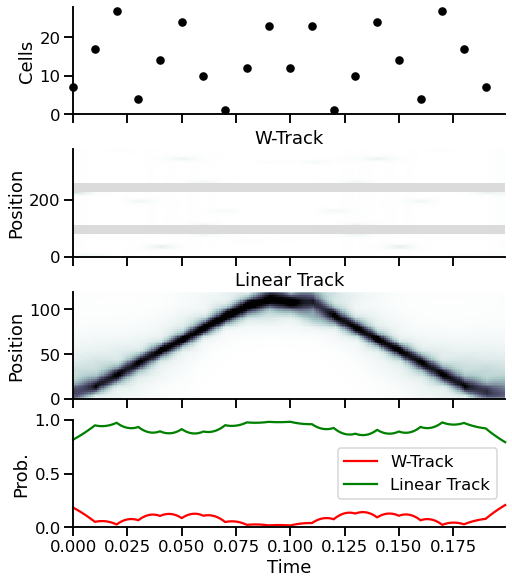

In [10]:
test_spikes = make_sequence([7, 17, 27, 4, 14, 24, 10, 1, 12, 23,
                             12, 23, 1, 10, 24, 14, 4, 27, 17, 7], 28, 10)

results = classifier.predict(test_spikes)

plot_replay_results(test_spikes, classifier, results)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


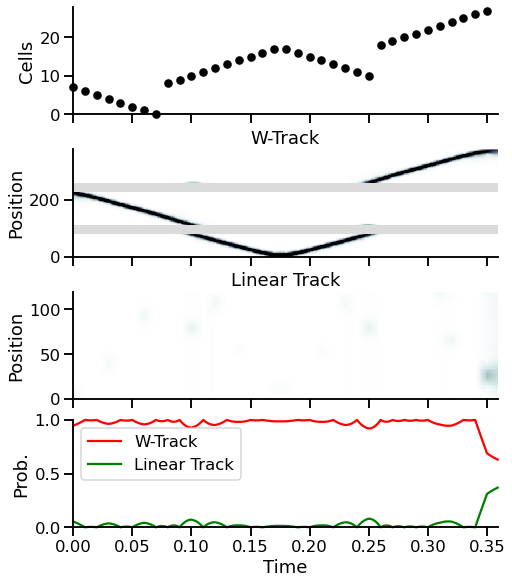

In [11]:
test_spikes = make_sequence([7, 6, 5, 4, 3, 2, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                             17, 16, 15, 14, 13, 12, 11, 10, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], 28, 10)

results = classifier.predict(test_spikes)

plot_replay_results(test_spikes, classifier, results)

In [12]:
classifier.predict(test_spikes)

INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...


<xarray.Dataset>
Dimensions:                (time: 360, state: 2, position: 162, wtrack_position: 162, linear_track_position: 60)
Coordinates:
  * time                   (time) int64 0 1 2 3 4 5 ... 354 355 356 357 358 359
  * state                  (state) <U14 'wtrack-0' 'linear_track-0'
  * wtrack_position        (wtrack_position) float64 1.0 3.0 5.0 ... 377.0 379.0
  * linear_track_position  (linear_track_position) float64 1.0 3.0 ... 119.0
Dimensions without coordinates: position
Data variables:
    likelihood             (time, state, position) float64 0.05083 ... 0.0
    causal_posterior       (time, state, position) float64 0.002254 ... 0.0
    acausal_posterior      (time, state, position) float64 3.306e-05 ... 0.0